In [1]:
import numpy as np

from qiskit_impl.decoders import decode_bpqm, decode_single_codeword, decode_single_syndrome, create_init_qc
from qiskit_impl.cloner import VarNodeCloner
from qiskit_impl.linearcode import LinearCode

from qiskit import QuantumCircuit


In [ ]:
B = np.array([[1, 0, 0, 1],
              [0, 1, 1, 0],
              [1, 0, 0, 1],
              [0, 1, 0, 0],
              [0, 1, 0, 1]])

H = B.T
# H = np.array([
#     [1, 0, 0, 0, 1],
#     [0, 1, 0, 1, 0],
#     [0, 0, 1, 0, 1],
#     [0, 1, 0, 1, 1],
# ])
# H = np.array([
#     [1, 1, 0, 0, 1, 0, 0, 0],
#     [0, 1, 1, 0, 0, 1, 0, 0],
#     [0, 0, 1, 1, 0, 0, 1, 0],
#     [1, 0, 0, 1, 0, 0, 0, 1],
# ])
theta = 0.2 * np.pi
cloner = VarNodeCloner(theta)
code = LinearCode(None, H)

corrupted_codeword = np.array([1, 1, 0, 1, 1])
syndrome = corrupted_codeword @ H.T %2
syndrome

array([1, 1, 1, 0])

In [19]:
# import numpy as np
# import itertools

# B = np.array([
#     [1, 1, 0, 0, 1, 0, 0, 0],
#     [0, 1, 1, 0, 0, 1, 0, 0],
#     [0, 0, 1, 1, 0, 0, 1, 0],
#     [1, 0, 0, 1, 0, 0, 0, 1],
# ])
# # 1) Enumerate all x in F2^4 with B @ x = 0 mod 2
# codewords = []
# for x in itertools.product([0,1], repeat=8):
#     x = np.array(x)
#     if np.all((B.dot(x) % 2) == 0):
#         codewords.append(x)

# # 2) Discard the zero codeword and compute weights
# nonzero = [x for x in codewords if x.any()]
# weights = [x.sum() for x in nonzero]
# d = min(weights) if weights else float('inf')
# print("Minimum distance d =", d)


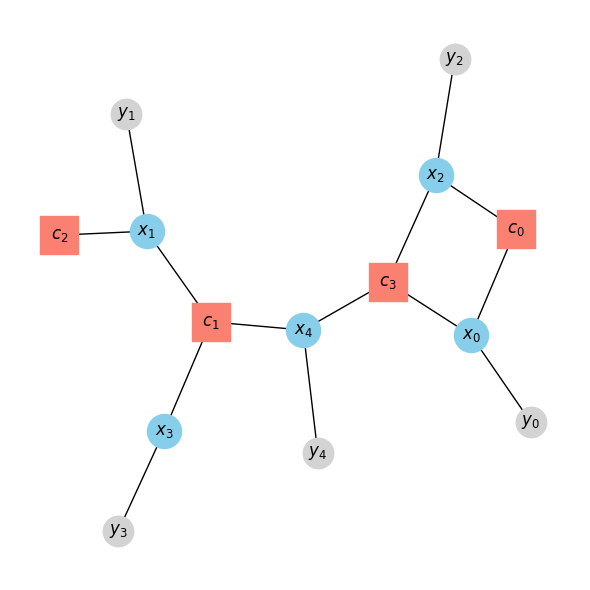

In [20]:
code.plot_factor_graph(backend="matplotlib")


In [21]:
code.get_computation_graph(f"x0", 2, syndrome_mode=True)

(<networkx.classes.digraph.DiGraph at 0x25ae3743bb0>,
 {'x0': 3, 'x1': 1, 'x2': 2, 'x3': 1, 'x4': 2},
 'x0_0')

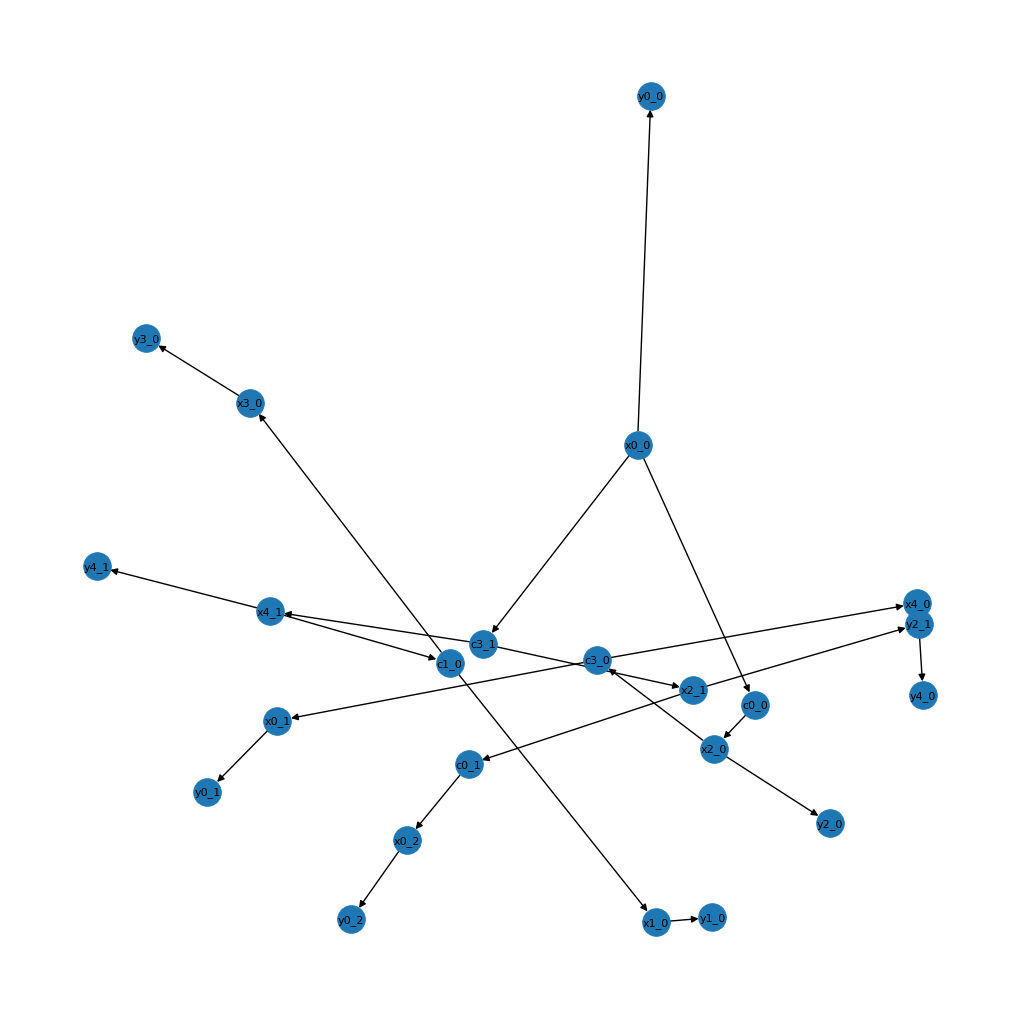

In [22]:
import matplotlib.pyplot as plt
import networkx as nx

# 1. Build your graph
G, qubit_map, root_label = code.get_computation_graph("x0", 2, syndrome_mode=True)
# for node in list(G.nodes()):
#     if G.nodes[node]["type"] == "check" and G.out_degree(node) == 0:
#         G.remove_node(node)
# 2a. Option A: Hierarchical (“dot”) layout

# 2b. Option B: Force‐directed layout (spring)
pos = nx.spring_layout(G, k=1.0, iterations=200)

# 3. Draw with a larger figure and some styling
plt.figure(figsize=(10, 10))
nx.draw(
    G,
    pos,
    with_labels=True,
    arrows=True,
    node_size=400,
    font_size=8,
    linewidths=0.5
)
plt.axis("off")
plt.show()


In [23]:
G.out_degree("c3_0")

2

In [24]:
syndrome_qc = QuantumCircuit(len(syndrome))
for i, s in enumerate(syndrome):
    if s == 1:
        syndrome_qc.x(i)

decoded_bits, decoded_qubits, qc_decode = decode_single_syndrome(
    syndrome_qc=syndrome_qc,
    code=code,
    prior=0.5,
    theta=theta,
    height=2,
    shots=10000,
    debug=True,
    run_simulation=True
)
print("syndrome             : ", syndrome)
print("Corrupted codeword   : ", corrupted_codeword)
print("Decoded bits         : ", decoded_bits)
if decoded_bits is not None:
    print("Decoded bits syndrome: ", decoded_bits @ H.T %2)

Counts:
  11011 → 1135 : syndrome [1 1 1 0]
  00101 → 1100 : syndrome [1 1 0 0]
  10001 → 1071 : syndrome [1 1 0 0]
  01111 → 1066 : syndrome [1 1 1 0]
  11000 → 546 : syndrome [1 1 1 1]
  01100 → 534 : syndrome [1 1 1 1]
  10010 → 495 : syndrome [1 1 0 1]
  00110 → 492 : syndrome [1 1 0 1]
  10000 → 348 : syndrome [1 0 0 1]
  11010 → 339 : syndrome [1 0 1 1]
  00100 → 335 : syndrome [1 0 0 1]
  01110 → 335 : syndrome [1 0 1 1]
  00010 → 177 : syndrome [0 1 0 0]
  01011 → 164 : syndrome [0 1 1 1]
  10110 → 161 : syndrome [0 1 0 0]
  11100 → 160 : syndrome [0 1 1 0]
  01000 → 156 : syndrome [0 1 1 0]
  11111 → 139 : syndrome [0 1 1 1]
  00001 → 138 : syndrome [0 1 0 1]
  10101 → 127 : syndrome [0 1 0 1]
  11110 → 118 : syndrome [0 0 1 0]
  00000 → 110 : syndrome [0 0 0 0]
  01010 → 97 : syndrome [0 0 1 0]
  00111 → 91 : syndrome [1 0 0 0]
  10100 → 89 : syndrome [0 0 0 0]
  11001 → 79 : syndrome [1 0 1 0]
  11101 → 75 : syndrome [0 0 1 1]
  00011 → 71 : syndrome [0 0 0 1]
  10011 → 69 :

In [25]:
qc_decode.count_ops()

OrderedDict([('cx', 173),
             ('x', 72),
             ('cz', 36),
             ('ucry', 36),
             ('ucry_dg', 36),
             ('ry', 18),
             ('barrier', 15),
             ('h', 10)])

In [26]:
qc_decode.num_qubits

18

In [27]:
qc_decode.depth()

269